In [1]:
#imports
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

import gensim

import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

from google.colab import files
import io

Using TensorFlow backend.


In [0]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
columns = ["target", "ids", "date", "flag", "user", "text"]
encoding = "ISO-8859-1"
train_size = 0.8

text_cleaning = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

#word2vec 
w2v_size = 300
w2v_window = 7
w2v_epoch = 32
w2v_min_count = 10

#keras
sequence_length = 300
epochs = 8
batch_size = 1024

#sentiments
positive = "positive"
negative = "negative"
neutral = "neutral"
thresholds = (0.4, 0.7)

#exports
keras_model = "sentiment.h5"
tokenizer_model = "tokenizer.pkl"

In [6]:
uploaded = files.upload()

Saving reviews.csv to reviews.csv


In [0]:
df = pd.read_csv(io.BytesIO(uploaded['reviews.csv']), encoding =encoding , names=columns)

In [0]:
decode_map = {0: "negative", 2: "neutral", 4: "positive"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 570 ms, sys: 2 ms, total: 572 ms
Wall time: 586 ms


Text(0.5, 1.0, 'Dataset labels distribution')

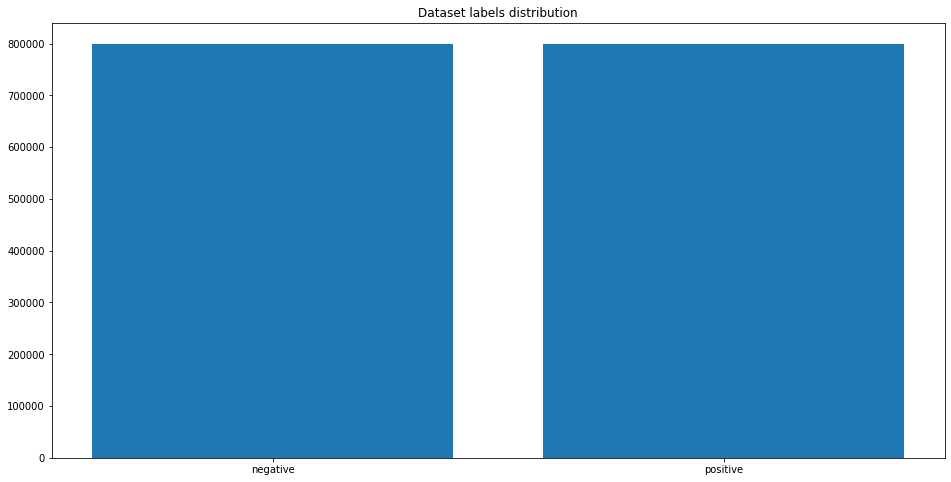

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribution")

In [0]:
#pre-processing
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 43.2 s, sys: 162 ms, total: 43.4 s
Wall time: 43.4 s


In [14]:
df_train, df_test = train_test_split(df, test_size=1-train_size, random_state=42)
print("train size:", len(df_train))
print("test size:", len(df_test))

train size: 1280000
test size: 320000


In [15]:
#word2vec
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.89 s, sys: 289 ms, total: 3.18 s
Wall time: 3.18 s


In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=w2v_size, 
                                            window=w2v_window, 
                                            min_count=w2v_min_count, 
                                            workers=8)

In [17]:
w2v_model.build_vocab(documents)

2019-11-02 15:47:15,980 : INFO : collecting all words and their counts
2019-11-02 15:47:15,983 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-11-02 15:47:16,016 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2019-11-02 15:47:16,039 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2019-11-02 15:47:16,066 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2019-11-02 15:47:16,090 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2019-11-02 15:47:16,113 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2019-11-02 15:47:16,137 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2019-11-02 15:47:16,161 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2019-11-02 15:47:16,185 : INFO : PROGRESS: at s

In [19]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("vocabulary size", vocab_size)

vocabulary size 30369


In [20]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=w2v_epoch)

2019-11-02 15:51:12,313 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-11-02 15:51:13,422 : INFO : EPOCH 1 - PROGRESS: at 4.24% examples, 318735 words/s, in_qsize 15, out_qsize 0
2019-11-02 15:51:14,455 : INFO : EPOCH 1 - PROGRESS: at 8.80% examples, 339970 words/s, in_qsize 14, out_qsize 1
2019-11-02 15:51:15,466 : INFO : EPOCH 1 - PROGRESS: at 13.25% examples, 346935 words/s, in_qsize 14, out_qsize 1
2019-11-02 15:51:16,513 : INFO : EPOCH 1 - PROGRESS: at 17.78% examples, 349468 words/s, in_qsize 16, out_qsize 1
2019-11-02 15:51:17,518 : INFO : EPOCH 1 - PROGRESS: at 22.22% examples, 352149 words/s, in_qsize 16, out_qsize 2
2019-11-02 15:51:18,569 : INFO : EPOCH 1 - PROGRESS: at 26.99% examples, 355648 words/s, in_qsize 15, out_qsize 0
2019-11-02 15:51:19,616 : INFO : EPOCH 1 - PROGRESS: at 31.43% examples, 354683 words/s, in_qsize 11, out_qsize 4
2019-11-02 15:51:20,649 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 23min 48s, sys: 5.4 s, total: 23min 54s
Wall time: 12min 14s


(263126189, 295270528)

In [22]:
w2v_model.most_similar("hate")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hates', 0.5698878169059753),
 ('sucks', 0.48134538531303406),
 ('stupid', 0.4725331664085388),
 ('dislike', 0.46621668338775635),
 ('suck', 0.45810794830322266),
 ('hating', 0.4370972812175751),
 ('despise', 0.43403005599975586),
 ('h8', 0.41227012872695923),
 ('ugh', 0.40906578302383423),
 ('annoying', 0.4016253352165222)]

In [23]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5781408548355103),
 ('loved', 0.5501092672348022),
 ('loves', 0.5437631607055664),
 ('adore', 0.5200071930885315),
 ('looove', 0.5072627663612366),
 ('amazing', 0.5015450716018677),
 ('loveee', 0.47942495346069336),
 ('awesome', 0.4718255400657654),
 ('lovee', 0.44959086179733276),
 ('loooove', 0.44744646549224854)]

In [25]:
#tokenizing the text
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("total words: ", vocab_size)

total words:  290419
CPU times: user 21.5 s, sys: 95.1 ms, total: 21.6 s
Wall time: 21.6 s


In [26]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=sequence_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=sequence_length)

CPU times: user 30.5 s, sys: 584 ms, total: 31.1 s
Wall time: 31.1 s


In [27]:
#label encoding
labels = df_train.target.unique().tolist()
labels.append(neutral)
labels

['positive', 'negative', 'neutral']

In [28]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [29]:
#text embedding layer
embedding_matrix = np.zeros((vocab_size, w2v_size))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [0]:
embedding_layer = Embedding(vocab_size, w2v_size, weights=[embedding_matrix], input_length=sequence_length, trainable=False)

In [0]:
#building model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [0]:
#callback functions
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [44]:
#training
%%time
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 1022s 887us/step - loss: 0.5033 - acc: 0.7517 - val_loss: 0.4654 - val_acc: 0.7788
Epoch 2/8
1152000/1152000 [==============================] - 1021s 886us/step - loss: 0.4812 - acc: 0.7657 - val_loss: 0.4574 - val_acc: 0.7840
Epoch 3/8
1152000/1152000 [==============================] - 1020s 885us/step - loss: 0.4740 - acc: 0.7709 - val_loss: 0.4561 - val_acc: 0.7859
Epoch 4/8
1152000/1152000 [==============================] - 1020s 885us/step - loss: 0.4698 - acc: 0.7730 - val_loss: 0.4515 - val_acc: 0.7877
Epoch 5/8
1152000/1152000 [==============================] - 1020s 886us/step - loss: 0.4677 - acc: 0.7744 - val_loss: 0.4523 - val_acc: 0.7883
Epoch 6/8
1152000/1152000 [==============================] - 1019s 885us/step - loss: 0.4656 - acc: 0.7760 - val_loss: 0.4494 - val_acc: 0.7899
Epoch 7/8
1152000/1152000 [==============================] - 1023s 888us/step - los

In [46]:
#testing
%%time
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print()
print("accuracy:",score[1])
print("loss:",score[0])

320000/320000 [==============================] - 111s 347us/step

accuracy: 0.790565625
loss: 0.44745776104927065
CPU times: user 1min 44s, sys: 10.2 s, total: 1min 54s
Wall time: 1min 50s


In [0]:
#predicting
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = neutral
        if score <= thresholds[0]:
            label = negative
        elif score >= thresholds[1]:
            label = positive

        return label
    else:
        return negative if score < 0.5 else positive

In [0]:
def predict(text, include_neutral=True):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=sequence_length)
    score = model.predict([x_test])[0]
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [60]:
predict("I love the food")

{'elapsed_time': 0.22563552856445312,
 'label': 'positive',
 'score': 0.9170794486999512}

In [66]:
predict("never again")

{'elapsed_time': 0.2417464256286621,
 'label': 'negative',
 'score': 0.25881290435791016}

In [68]:
#confusion matrix
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 67s 211us/step


In [69]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.79      0.79      0.79    159494
    positive       0.79      0.79      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [70]:
model.save(keras_model)
w2v_model.save("model.w2v")
pickle.dump(tokenizer, open(tokenizer_model, "wb"), protocol=0)
pickle.dump(encoder, open("encoder.pkl", "wb"), protocol=0)

2019-11-02 19:49:56,174 : INFO : saving Word2Vec object under model.w2v, separately None
2019-11-02 19:49:56,175 : INFO : not storing attribute vectors_norm
2019-11-02 19:49:56,180 : INFO : not storing attribute cum_table
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-11-02 19:49:57,096 : INFO : saved model.w2v


In [71]:
!ls

encoder.pkl  model.w2v	reviews.csv  sample_data  sentiment.h5	tokenizer.pkl
